In [3]:
from tifffile import imread
import os
from matplotlib import pyplot as plt
import json
from scipy.io import loadmat
import h5py
import numpy as np
import pandas as pd

In [4]:
pth_WSI_segmentations = r'\\10.162.80.16\Andre_expansion\data\monkey_fetus\Stardist\liver_cell_annotations\jsons'
npdi_im_path = r'\\10.162.80.16\Andre_expansion\data\monkey_fetus\Stardist\liver_cell_annotations'
hep_geojson_file = r'\\10.162.80.16\Andre_expansion\data\monkey_fetus\Stardist\liver_cell_annotations\geojsons_cell_type_annotations\monkey_fetus_40_0466_hepatoblast.geojson'
eryth_geojson_file = r'\\10.162.80.16\Andre_expansion\data\monkey_fetus\Stardist\liver_cell_annotations\geojsons_cell_type_annotations\monkey_fetus_40_0466_erythropoietic.geojson'

pth_dfs = r'\\10.162.80.16\Andre_expansion\data\monkey_fetus\Stardist\liver_cell_annotations\dfs'

In [5]:
json_pth_list = [os.path.join(pth_WSI_segmentations,file) for file in os.listdir(pth_WSI_segmentations) if file.endswith(".json")]
print(json_pth_list)

['\\\\10.162.80.16\\Andre_expansion\\data\\monkey_fetus\\Stardist\\liver_cell_annotations\\jsons\\monkey_fetus_40_0466.json', '\\\\10.162.80.16\\Andre_expansion\\data\\monkey_fetus\\Stardist\\liver_cell_annotations\\jsons\\monkey_fetus_40_0552.json', '\\\\10.162.80.16\\Andre_expansion\\data\\monkey_fetus\\Stardist\\liver_cell_annotations\\jsons\\monkey_fetus_40_0642.json']


In [6]:
im_list = os.listdir(npdi_im_path)
im_list = [im for im in im_list if im.endswith('.ndpi')]

In [7]:
# read one image
ind = 0

HE_20x_WSI = imread(os.path.join(npdi_im_path, im_list[ind]))

In [8]:
def show_tile(tile, **kwargs):
    """Plot a single image."""
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(tile, **kwargs)
    plt.tight_layout()
    ax.set_axis_off()
    plt.show()

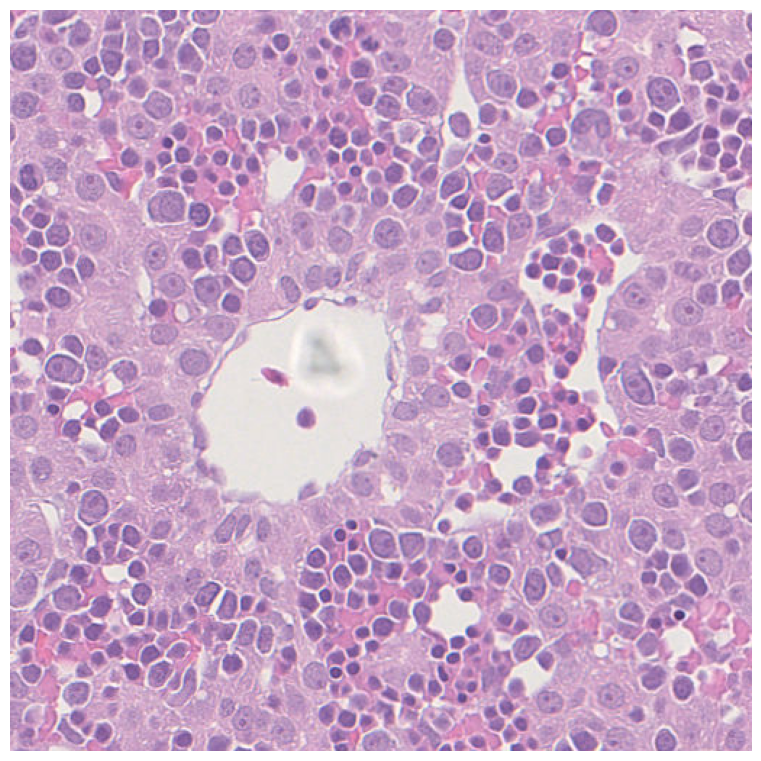

In [9]:
crop_x = 22611
crop_y = 14222
tile_size = 512

HE_20x_tile = HE_20x_WSI[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

show_tile(HE_20x_tile)

In [10]:
hep_geo_data = json.load(open(hep_geojson_file))
print(hep_geojson_file)
print(hep_geo_data.keys())

\\10.162.80.16\Andre_expansion\data\monkey_fetus\Stardist\liver_cell_annotations\geojsons_cell_type_annotations\monkey_fetus_40_0466_hepatoblast.geojson
dict_keys(['type', 'features'])


In [11]:
eryth_geo_data = json.load(open(eryth_geojson_file))
print(eryth_geojson_file)
print(eryth_geo_data.keys())

\\10.162.80.16\Andre_expansion\data\monkey_fetus\Stardist\liver_cell_annotations\geojsons_cell_type_annotations\monkey_fetus_40_0466_erythropoietic.geojson
dict_keys(['type', 'features'])


In [12]:
hep_centroids_ann = []

for i in range(len(hep_geo_data['features'])):
    data = hep_geo_data['features'][i]
    coords = data['geometry']['coordinates'][0]
    
    x_cent = 0
    y_cent = 0
    for pair in coords:
        x_cent += pair[1] #+ crop_y
        y_cent += pair[0] #+ crop_x
    x_cent /= len(coords)
    y_cent /= len(coords)
    
    # print(x_cent, y_cent)
    hep_centroids_ann.append([x_cent, y_cent])
    
eryth_centroids_ann = []

for i in range(len(eryth_geo_data['features'])):
    data = eryth_geo_data['features'][i]
    coords = data['geometry']['coordinates'][0]
    
    x_cent = 0
    y_cent = 0
    for pair in coords:
        x_cent += pair[1] #+ crop_y
        y_cent += pair[0] #+ crop_x
    x_cent /= len(coords)
    y_cent /= len(coords)
    
    # print(x_cent, y_cent)
    eryth_centroids_ann.append([x_cent, y_cent])

In [13]:
print(json_pth_list[ind])
segmentation_data = json.load(open(json_pth_list[ind]))

# centroids = [nuc['centroid'][0] for nuc in segmentation_data]  # I wrote bad centroids in json file, but contours are right
contours = [nuc['contour'] for nuc in segmentation_data]
centroids = [[np.mean(xy[0][0]), np.mean(xy[0][1])] for xy in contours]
print(len(centroids))
print(len(contours))

\\10.162.80.16\Andre_expansion\data\monkey_fetus\Stardist\liver_cell_annotations\jsons\monkey_fetus_40_0466.json
569769
569769


In [14]:
hep_centroids_ann_np = np.array(hep_centroids_ann)
eryth_centroids_ann_np = np.array(eryth_centroids_ann)

centroids_total_np = np.array(centroids)

print(len(hep_centroids_ann_np))
print(len(eryth_centroids_ann_np))
print(len(centroids_total_np))

250
250
569769


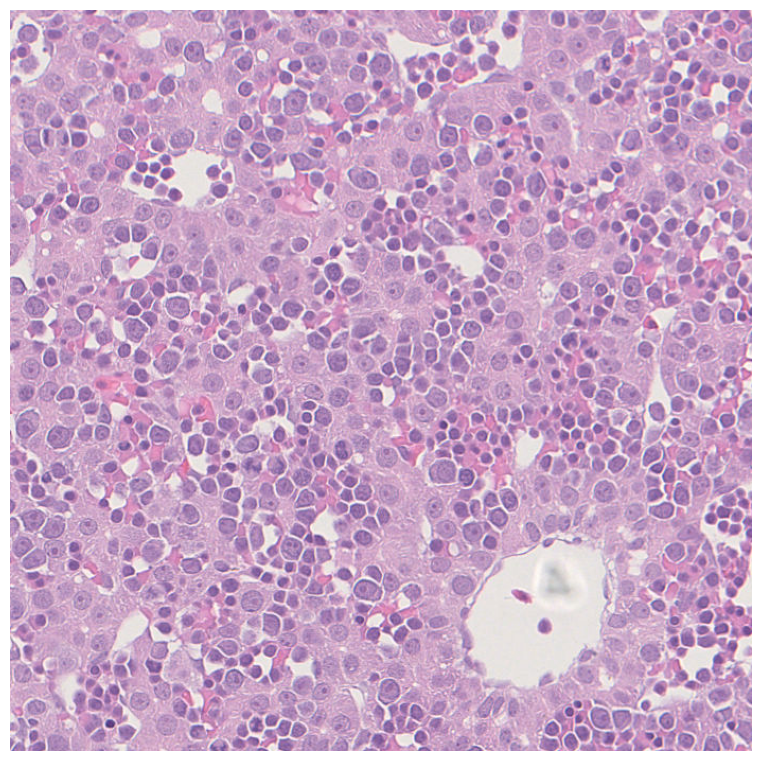

In [15]:
crop_x = 22311
crop_y = 13922
tile_size = 700

HE_20x_tile = HE_20x_WSI[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

show_tile(HE_20x_tile)

In [16]:
# https://stackoverflow.com/questions/71027729/finding-optimal-nearest-neighbour-pairs

# match closest pairs of coordinates in two sets of x,y coordinates

from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, csgraph

def colocalize_points(points_a: np.ndarray, points_b: np.ndarray, r: int):
    """ Find pairs that minimize global distance. Filters out anything outside radius `r` """

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(points_b)
    distances, b_indices = neigh.radius_neighbors(points_a, radius=r)

    # flatten and get indices for A. This will also drop points in A with no matches in range
    d_flat = np.hstack(distances) + 1
    b_flat = np.hstack(b_indices)
    a_flat = np.array([i for i, neighbors in enumerate(distances) for n in neighbors])

    # filter out A points that cannot be matched
    sm = csr_matrix((d_flat, (a_flat, b_flat)))
    a_matchable = csgraph.maximum_bipartite_matching(sm, perm_type='column')
    sm_filtered = sm[a_matchable != -1]

    # now run the distance minimizing matching
    row_match, col_match = csgraph.min_weight_full_bipartite_matching(sm_filtered)
    return row_match, col_match

In [17]:
hep_results = colocalize_points(hep_centroids_ann_np, centroids_total_np, r=20)
eryth_results = colocalize_points(eryth_centroids_ann_np, centroids_total_np, r=20)

In [18]:
def adjust_contours(contours_matched, x, y):

    contours_matched_adjusted = []
    for i in range(len(contours_matched)):
        contour = contours_matched[i][0]
        x_coords = contour[0]
        y_coords = contour[1]
        x_coords = [point-x for point in x_coords]
        y_coords = [point-y for point in y_coords]
        
        shape = list(zip(x_coords, y_coords))
        contours_matched_adjusted.append(shape)
    
    return contours_matched_adjusted

In [19]:
def get_contours_for_plot(results, centroids_ann_np, centroids_total_np):
    centroids_annotated = [centroids_ann_np[i] for i in results[0]]
    centroids_all = [centroids_total_np[i] for i in results[1]]
    centroids_matched = [pair.tolist() for pair in centroids_all]

    adj_centroids_matched = [[pair[0] - crop_y, pair[1] - crop_x] for pair in centroids_matched]
    
    adj_centroids = [[pair[0] - crop_y, pair[1] - crop_x] for pair in centroids]
    centroids_in_tile_seg = [pair for pair in adj_centroids if 0 < crop_y < tile_size and 0 < crop_x < tile_size and pair not in adj_centroids_matched]
    
    indices_matched = [adj_centroids.index(pair) for pair in adj_centroids if pair in adj_centroids_matched]
    
    indices_not_matched = [adj_centroids.index(pair) for pair in adj_centroids if 0 < pair[1] < tile_size and 0 < pair[0] < tile_size and pair not in adj_centroids_matched]  # and within crop range
    
    contours_matched = [contours[i] for i in indices_matched]
    contours_not_matched = [contours[i] for i in indices_not_matched] 
    
    contours_matched_adjusted = adjust_contours(contours_matched, crop_y, crop_x)
    contours_not_matched_adjusted = adjust_contours(contours_not_matched, crop_y, crop_x)
    
    return contours_matched_adjusted, indices_matched

In [20]:
hep_contours_matched_ajd, hep_indices_matched = get_contours_for_plot(hep_results, hep_centroids_ann_np, centroids_total_np)
eryth_contours_matched_ajd, eryth_indices_matched = get_contours_for_plot(eryth_results, eryth_centroids_ann_np, centroids_total_np)

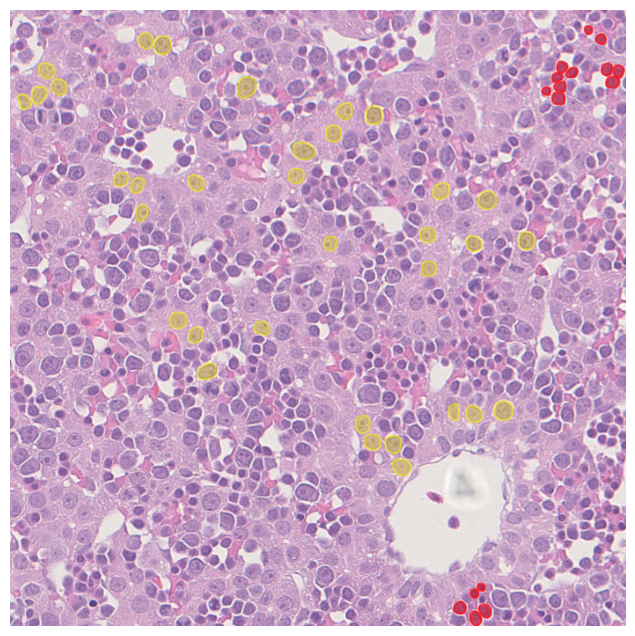

In [21]:
hep_reversed_contours = [[(y, x) for x, y in polygon] for polygon in hep_contours_matched_ajd]
eryth_reversed_contours = [[(y, x) for x, y in polygon] for polygon in eryth_contours_matched_ajd]

fig, ax = plt.subplots(figsize=(16, 8))

# Plot the image
ax.imshow(HE_20x_tile)
ax.set_axis_off()

for polygon in hep_reversed_contours:
    x_coords, y_coords = zip(*polygon)
    x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
    y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon

    color = 'yellow'
    
    skip = False
    for x in x_coords:
        if x < 0 or x > (tile_size - 1):
            skip = True
            break
    for y in y_coords:
        if y < 0 or y > (tile_size - 1):
            skip = True
            break
    
    if not skip:
        ax.plot(x_coords, y_coords, alpha=0.3, color=color)
        ax.fill(x_coords, y_coords, alpha=0.3, color=color)  # Fill the polygon
    

for polygon in eryth_reversed_contours:
    x_coords, y_coords = zip(*polygon)
    x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
    y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon

    color = 'red'
    
    skip = False
    for x in x_coords:
        if x < 0 or x > (tile_size - 1):
            skip = True
            break
    for y in y_coords:
        if y < 0 or y > (tile_size - 1):
            skip = True
            break
    
    if not skip:

        ax.plot(x_coords, y_coords, alpha=0.4, color=color)
        ax.fill(x_coords, y_coords, alpha=0.4, color=color)  # Fill the polygon

# Set labels and title for the plot
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
#ax.set_title('Qupath selected nuclei vs unselected')

plt.show()

In [22]:
df_pth_list = [os.path.join(pth_dfs,x) for x in os.listdir(pth_dfs)]

In [23]:
df_pth_list[0]

'\\\\10.162.80.16\\Andre_expansion\\data\\monkey_fetus\\Stardist\\liver_cell_annotations\\dfs\\monkey_fetus_40_0466.pkl'

In [24]:
import pickle

with open(df_pth_list[0], 'rb') as file:
    df = pickle.load(file)

In [25]:
print(df.shape)
print(len(centroids))
print(len(contours))

(569769, 20)
569769
569769


In [26]:
hep_df = df.iloc[hep_indices_matched,:]
eryth_df = df.iloc[eryth_indices_matched,:]

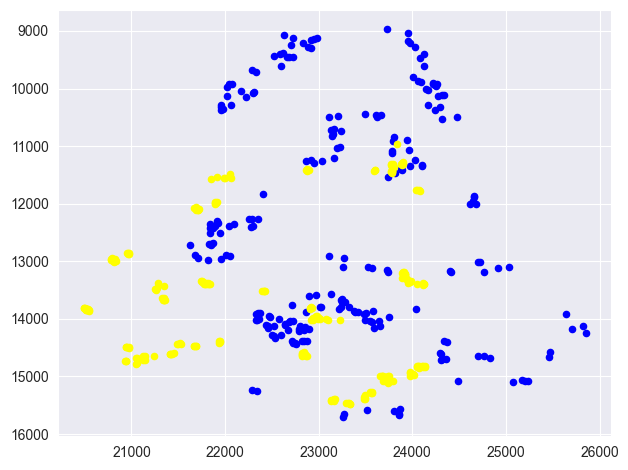

In [27]:
plt.scatter(hep_df['Centroid_x'], hep_df['Centroid_y'], c='blue', s=20)
plt.scatter(eryth_df['Centroid_x'], eryth_df['Centroid_y'], c='yellow', s=20)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [28]:
hep_df

Centroid_x  Centroid_y        Area  Perimeter  Circularity  \
168689     22660.0      9458.0   93.861595  36.699089     0.875764   
170654     24094.0      9884.0   98.156807  35.912983     0.956373   
172209     23726.0      8972.0  281.455994  61.534843     0.934067   
172221     23956.0      9178.0  252.865005  57.172073     0.972144   
172521     23110.0     10502.0  210.799515  52.460644     0.962526   
...            ...         ...         ...        ...          ...   
469229     25204.0     15072.0  261.459808  59.174080     0.938322   
469413     24322.0     14700.0  330.047394  66.019806     0.951563   
469414     24292.0     14592.0  343.066101  66.913383     0.962857   
469599     25172.0     15054.0  350.276642  67.692627     0.960591   
469910     24308.0     14608.0  255.837814  57.541370     0.970989   

        Aspect Ratio  compactness  eccentricity    extent  form_factor  \
168689      1.326375    14.349032      0.656950  0.771091     1.141860   
170654      1.096130    13.139610      0.409521  0.774768     1.045617   
172209      1.369493    13.453388      0.683236  0.775145     1.070587   
172221      1.084874    12.926447      0.387747  0.777955     1.028654   
172521      1.203122    13.055623      0.556017  0.777080     1.038934   
...              ...          ...           ...       ...          ...   
469229      1.375959    13.392389      0.686885  0.774832     1.065732   
469413      1.232219    13.206028      0.584291  0.775823     1.050902   
469414      1.093558    13.051129      0.404707  0.775816     1.038576   
469599      1.058607    13.081922      0.328114  0.774569     1.041026   
469910      1.127156    12.941829      0.461406  0.778235     1.029878   

        maximum_radius  mean_radius  median_radius  minor_axis_length  \
168689        7.350734     5.419937       5.216389           9.579835   
170654        6.452393     5.594481       5.560056          10.750868   
172209       11.463686     9.432269       9.238260          16.282986   
172221        9.851697     8.991592       9.010938          17.309219   
172521        9.870493     8.167806       8.245784          15.015752   
...                ...          ...            ...                ...   
469229       10.959262     9.073375       9.212380          15.660153   
469413       12.679114    10.201978      10.362234          18.580729   
469414       11.474430    10.463621      10.626300          20.108919   
469599       11.973433    10.561401      10.989968          20.668467   
469910       10.605914     9.007911       9.179665          17.077921   

        major_axis_length  orientation_degrees  r_mean_intensity  \
168689          12.706455          8469.908203        156.500000   
170654          11.784345          5226.509277        163.710007   
172209          22.299431          3730.507324        177.089996   
172221          18.778326          7061.151855        188.320007   
172521          18.065786          7975.950684        185.360001   
...                   ...                  ...               ...   
469229          21.547724          4021.643799        189.039993   
469413          22.895527          5788.359375        167.080002   
469414          21.990265          2401.014648        178.169998   
469599          21.879774          7726.605469        184.380005   
469910          19.249474          4701.363770        185.639999   

        g_mean_intensity  b_mean_intensity  slide_num  
168689        120.639999        171.279999      466.0  
170654        121.599998        173.050003      466.0  
172209        142.539993        185.759995      466.0  
172221        159.080002        194.050003      466.0  
172521        153.300003        191.929993      466.0  
...                  ...               ...        ...  
469229        155.279999        194.539993      466.0  
469413        131.699997        180.020004      466.0  
469414        140.690002        185.309998      466.0  
469599        149.699997

In [29]:
def fix_scale(dat):

    ds = 0.4416/0.5*4
    
    dat['Area'] = dat['Area']/ds
    dat['Perimeter'] = dat['Perimeter']/ds
    dat['maximum_radius'] = dat['maximum_radius']/ds
    dat['mean_radius'] = dat['mean_radius']/ds
    dat['minor_axis_length'] = dat['minor_axis_length']/ds
    dat['major_axis_length'] = dat['major_axis_length']/ds
    
    return dat

In [30]:
hep_df2 = fix_scale(hep_df.copy())
eryth_df2 = fix_scale(eryth_df.copy())

In [31]:
cols_to_select = ['Area', 'Perimeter', 'Circularity', 'Aspect Ratio', 'compactness',
       'eccentricity', 'extent', 'form_factor', 'maximum_radius',
       'mean_radius', 'minor_axis_length', 'major_axis_length',
       'r_mean_intensity', 'g_mean_intensity',
       'b_mean_intensity']

good_names = ['Area (um)', 'Perimeter (um)', 'Circularity', 'Aspect Ratio', 'Compactness',
       'Eccentricity', 'Extent', 'Form Factor', 'Maximum Radius (um)',
       'Mean Radius (um)', 'Minor Axis Length (um)', 'Major Axis Length (um)',
       'Mean R Intensity', 'Mean G Intensity',
       'Mean B Intensity']

In [32]:
hep_df2['class'] = [1 for _ in range(len(hep_df2))]
eryth_df2['class'] = [2 for _ in range(len(eryth_df2))]

df_combined = pd.concat([hep_df2, eryth_df2], ignore_index=True)

In [33]:
df_combined.shape

(480, 21)

In [34]:
df_combined.head()

Centroid_x  Centroid_y       Area  Perimeter  Circularity  Aspect Ratio  \
0     22660.0      9458.0  26.568613  10.388103     0.875764      1.326375   
1     24094.0      9884.0  27.784422  10.165586     0.956373      1.096130   
2     23726.0      8972.0  79.669380  17.418152     0.934067      1.369493   
3     23956.0      9178.0  71.576370  16.183218     0.972144      1.084874   
4     23110.0     10502.0  59.669247  14.849593     0.962526      1.203122   

   compactness  eccentricity    extent  form_factor  ...  mean_radius  \
0    14.349032      0.656950  0.771091     1.141860  ...     1.534176   
1    13.139610      0.409521  0.774768     1.045617  ...     1.583583   
2    13.453388      0.683236  0.775145     1.070587  ...     2.669913   
3    12.926447      0.387747  0.777955     1.028654  ...     2.545175   
4    13.055623      0.556017  0.777080     1.038934  ...     2.311992   

   median_radius  minor_axis_length  major_axis_length  orientation_degrees  \
0       5.216389           2.711683           3.596709          8469.908203   
1       5.560056           3.043158           3.335696          5226.509277   
2       9.238260           4.609088           6.312112          3730.507324   
3       9.010938           4.899575           5.315423          7061.151855   
4       8.245784           4.250383           5.113730          7975.950684   

   r_mean_intensity  g_mean_intensity  b_mean_intensity  slide_num  class  
0        156.500000        120.639999        171.279999      466.0      1  
1        163.710007        121.599998        173.050003      466.0      1  
2        177.089996        142.539993        185.759995      466.0      1  
3        188.320007        159.080002        194.050003      466.0      1  
4        185.360001        153.300003        191.929993      466.0      1  

[5 rows x 21 columns]

In [35]:
import seaborn as sns

cmap = [[235, 212, 200],
        [137, 151, 206]]

cmap = [[r/255, g/255, b/255] for r, g, b in cmap]

titles = ["Hepatoblast", "Erythropoietic"]

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define your custom colormap
colors = [[209/255,214/255,125/255],'red']  # Colors for each class
cmap_name = 'custom_cma'
custom_cm = mcolors.ListedColormap(colors, name=cmap_name)

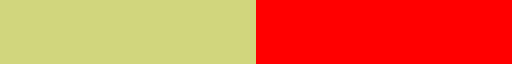

In [54]:
custom_cm

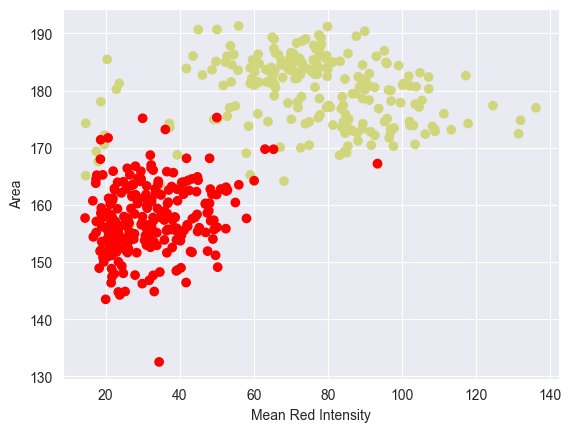

In [57]:
feature1= "Area"
feature2= "r_mean_intensity"
#plt.register_cmap(cmap=custom_cm)
plt.scatter(df_combined[feature1], df_combined[feature2],c=df_combined['class'],cmap='custom_cma')
plt.ylabel(feature1)
#plt.xlabel(feature2)
plt.xlabel("Mean Red Intensity")
plt.savefig(fr'C:\Users\Donald\PycharmProjects\monkey_nuc_segment\Segmentation_Analysis\monkey\stardist_volcell\liver_cell_determination\figs\area_v_r_plot.png', dpi=300)
plt.show()

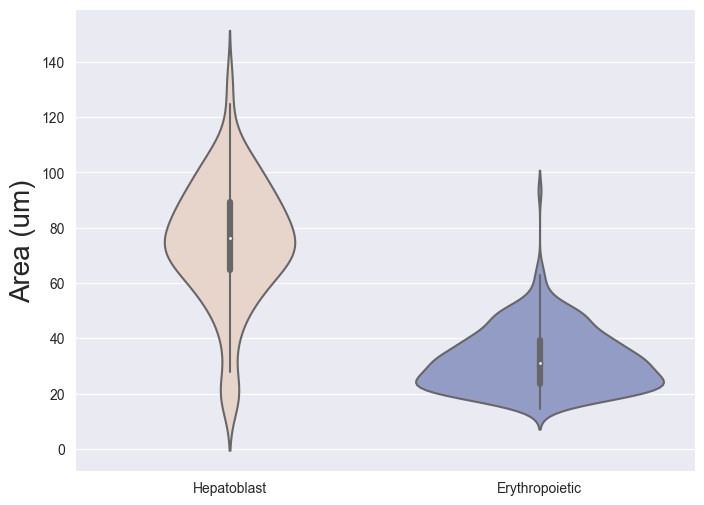

In [60]:
i=0

fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(x="class", y=f"{cols_to_select[i]}", data=df_combined,palette=cmap,inner='box', inner_kws=dict(box_width=15, whis_width=2, color=".8"))
#sns.boxplot(x="class", y=f"{cols_to_select[i]}", data=df_combined, width=0.05)
ax.set_xticklabels(titles)
ax.set_xlabel('')
ax.set_ylabel(f'{good_names[i]}', fontsize=20)
plt.savefig(fr'C:\Users\Donald\PycharmProjects\monkey_nuc_segment\Segmentation_Analysis\monkey\stardist_volcell\liver_cell_determination\figs\{good_names[i]}_plot.png', dpi=300)
# plt.close()  # Close the current figure to free up memory
plt.show()

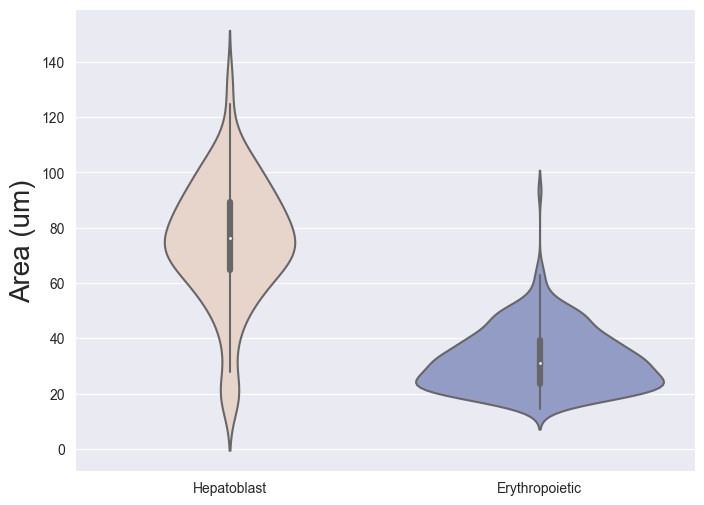

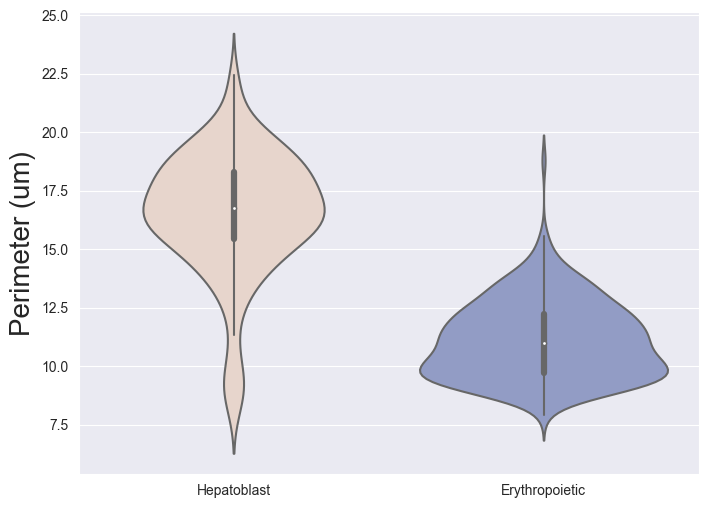

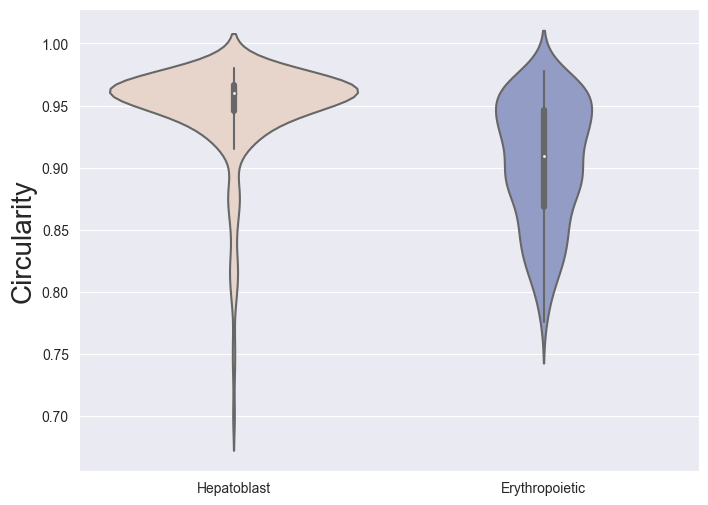

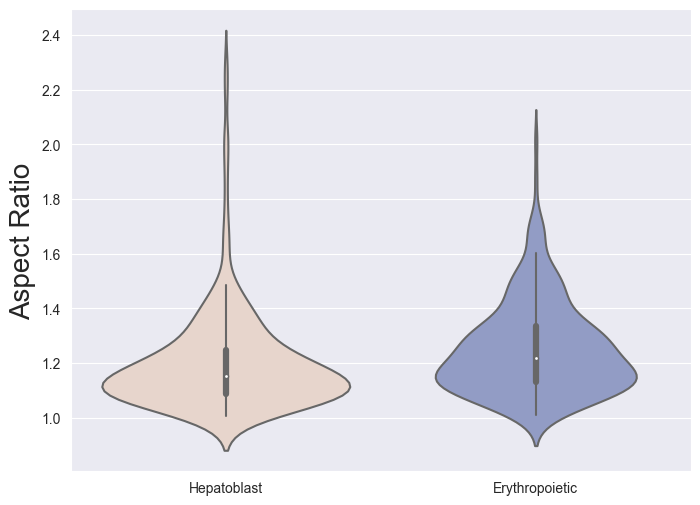

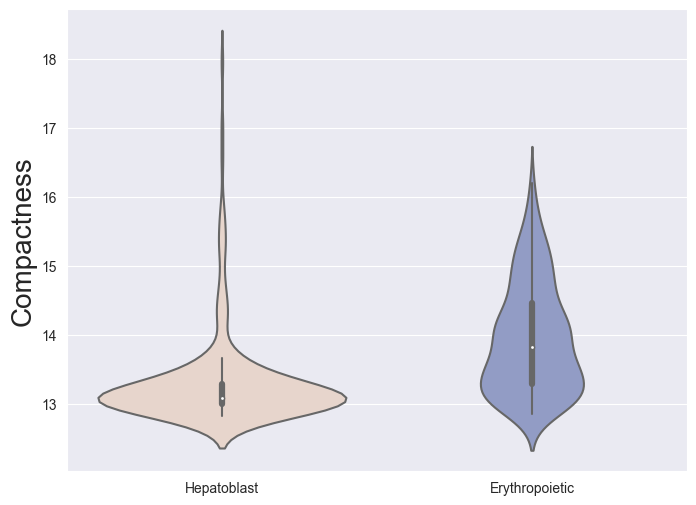

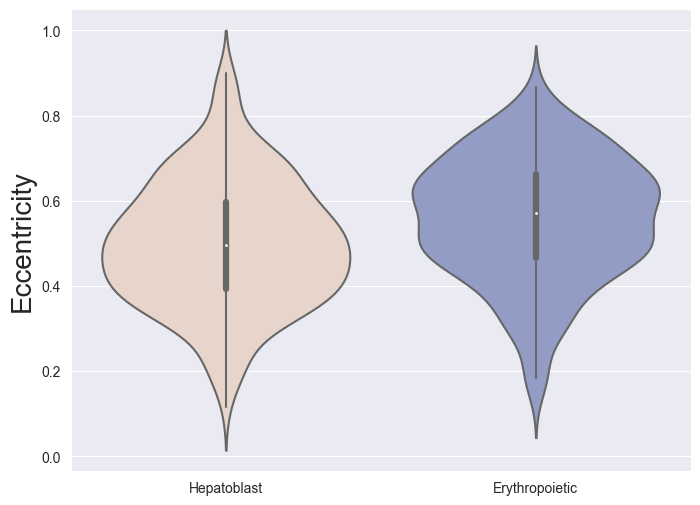

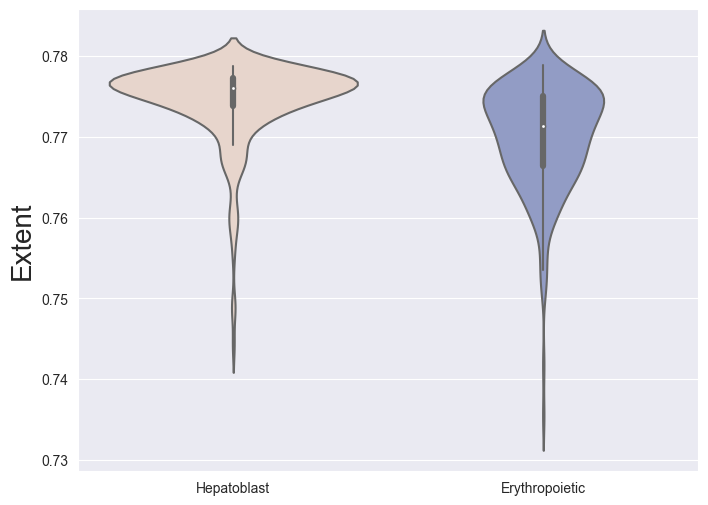

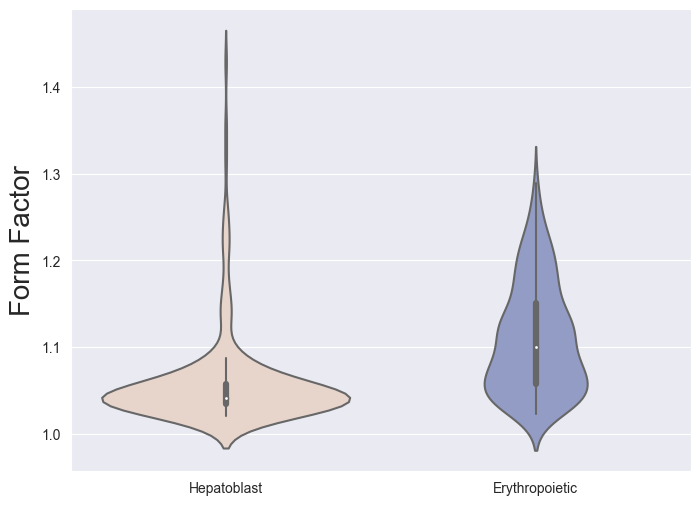

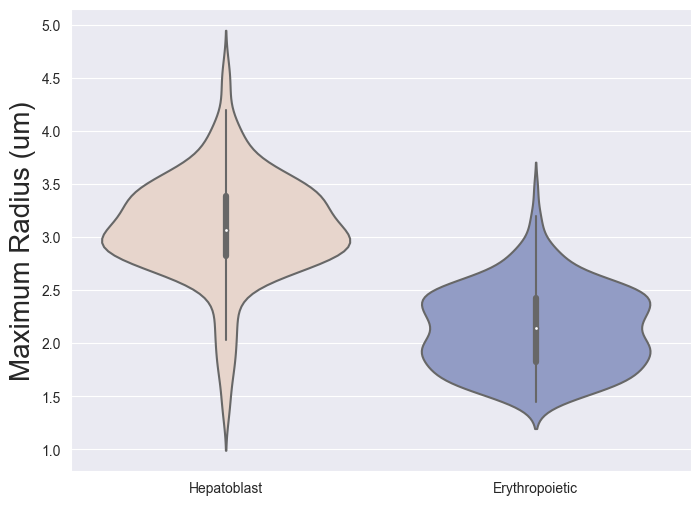

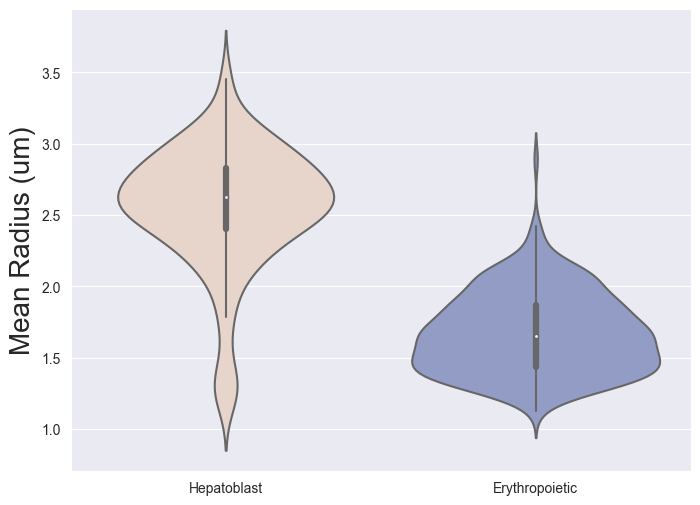

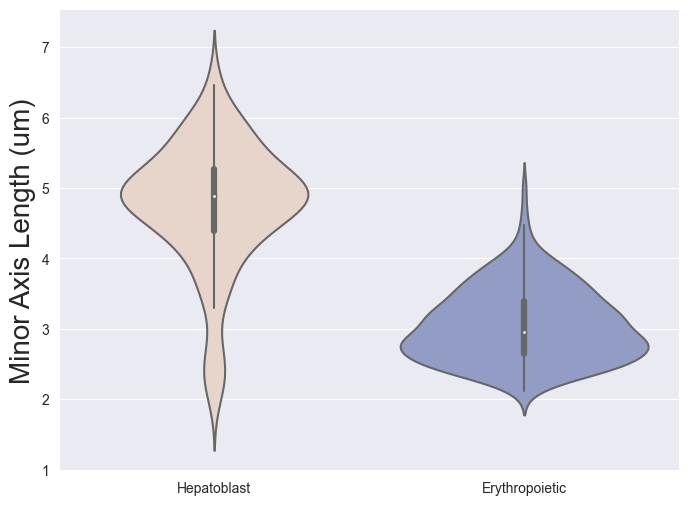

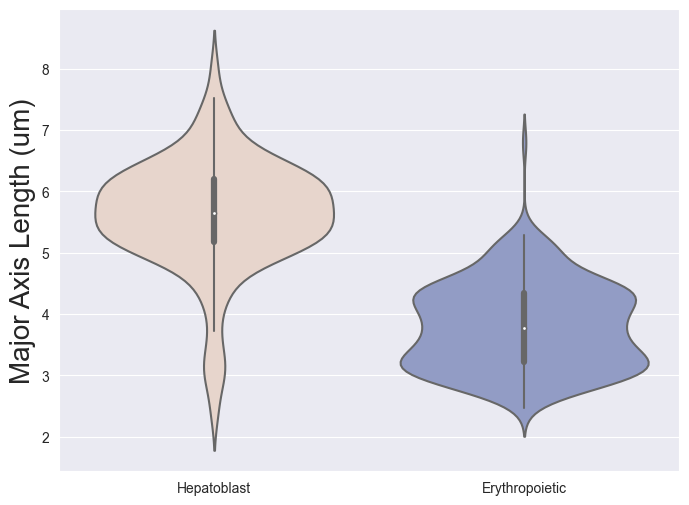

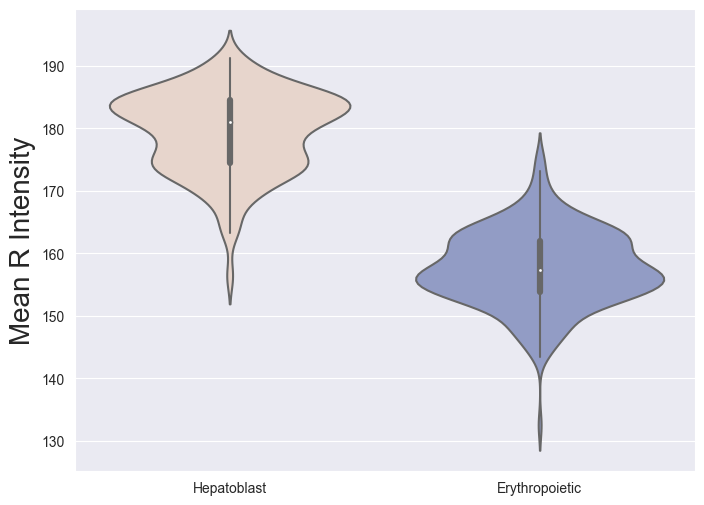

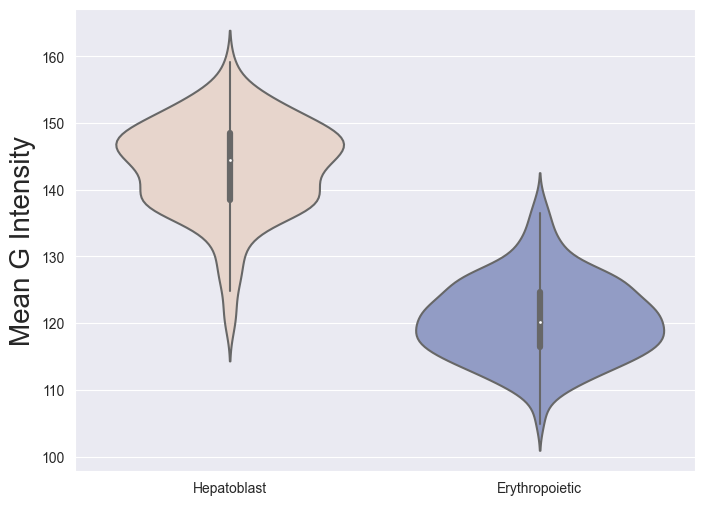

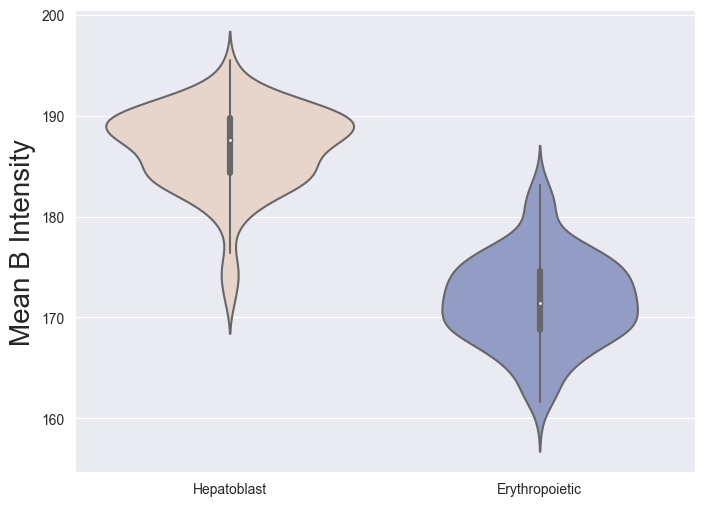

In [61]:
for i in range(len(cols_to_select)):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.violinplot(x="class", y=f"{cols_to_select[i]}", data=df_combined,palette=cmap)
    ax.set_xticklabels(titles)
    ax.set_xlabel('')
    ax.set_ylabel(f'{good_names[i]}', fontsize=20)
    plt.savefig(fr'C:\Users\Donald\PycharmProjects\monkey_nuc_segment\Segmentation_Analysis\monkey\stardist_volcell\liver_cell_determination\figs\{good_names[i]}_plot.png', dpi=300)
    # plt.close()  # Close the current figure to free up memory
    plt.show()

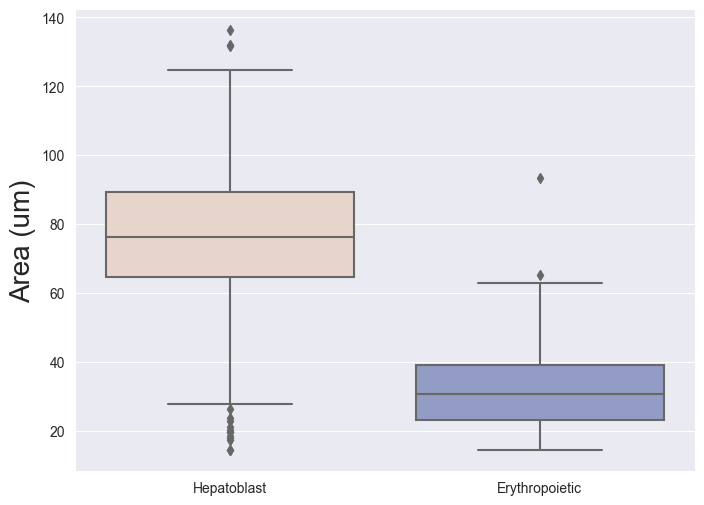

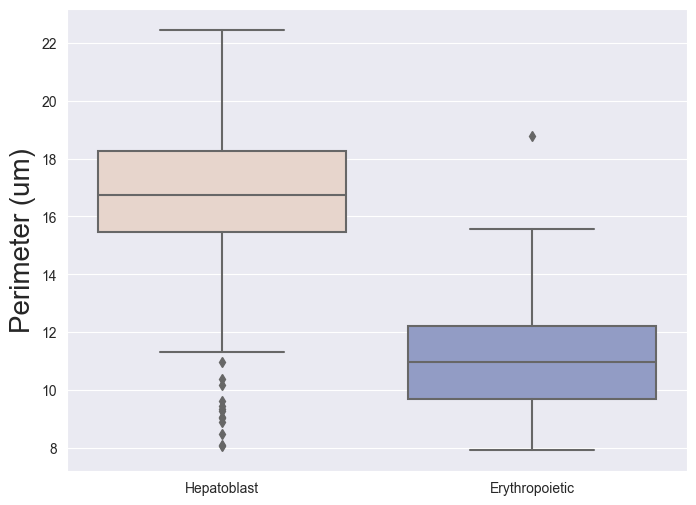

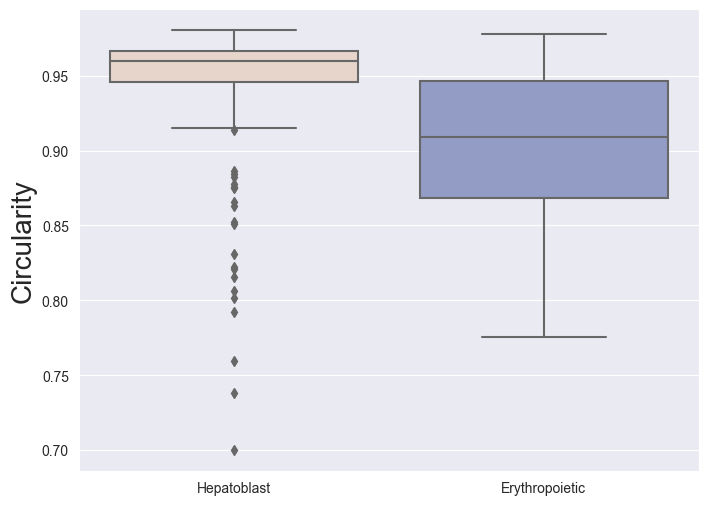

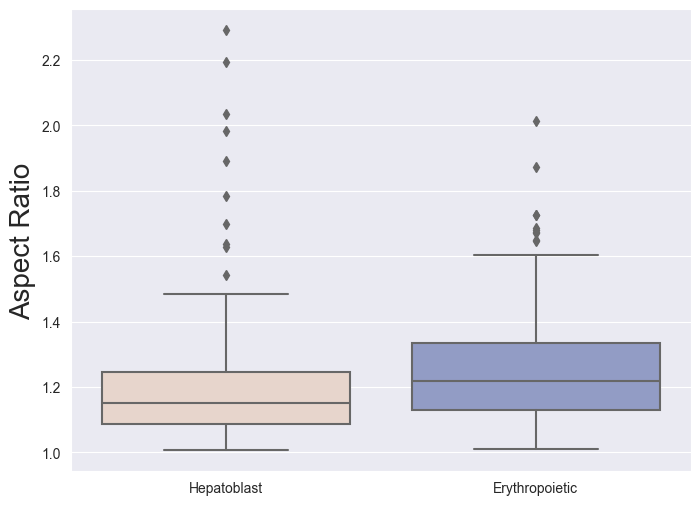

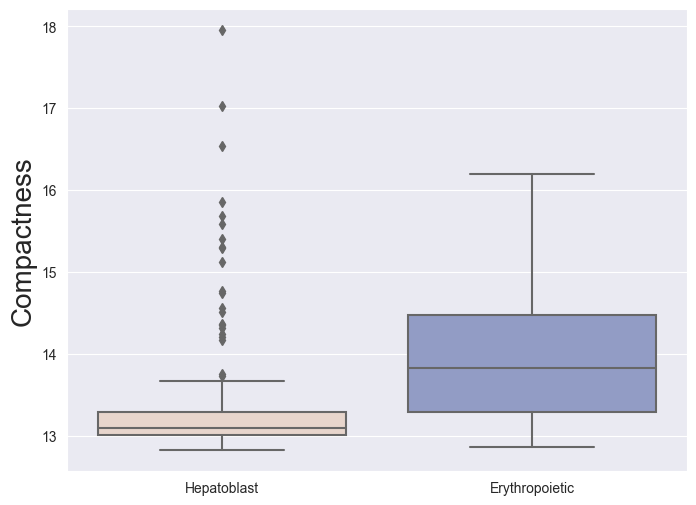

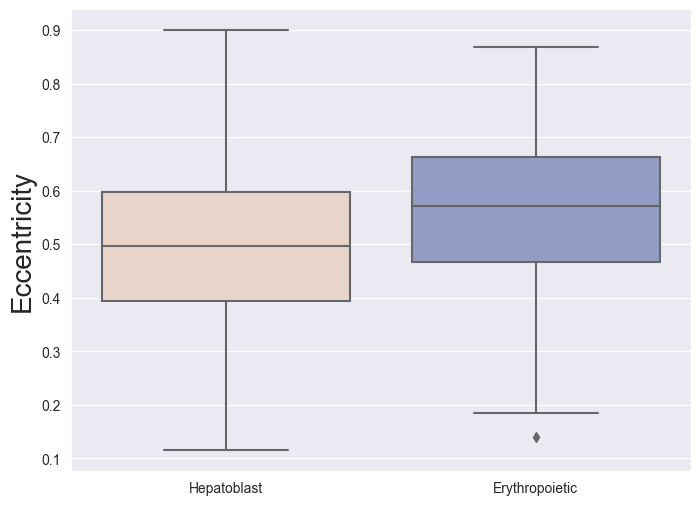

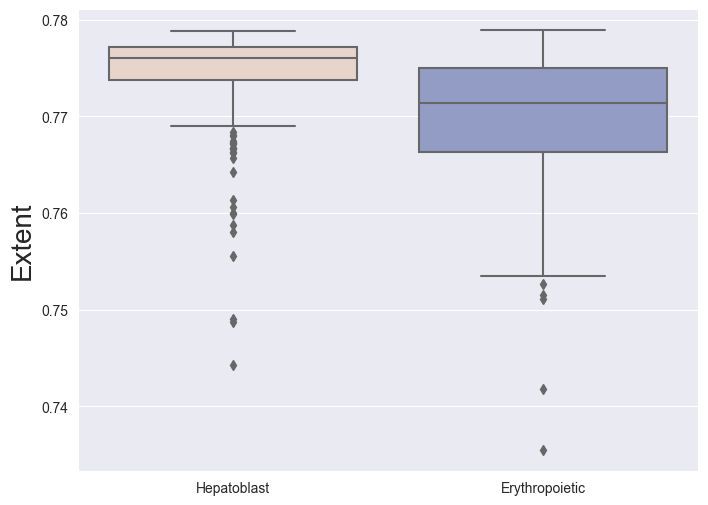

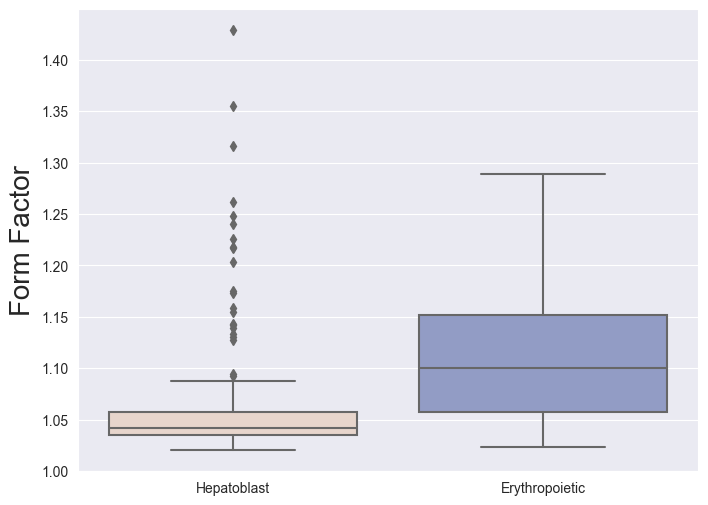

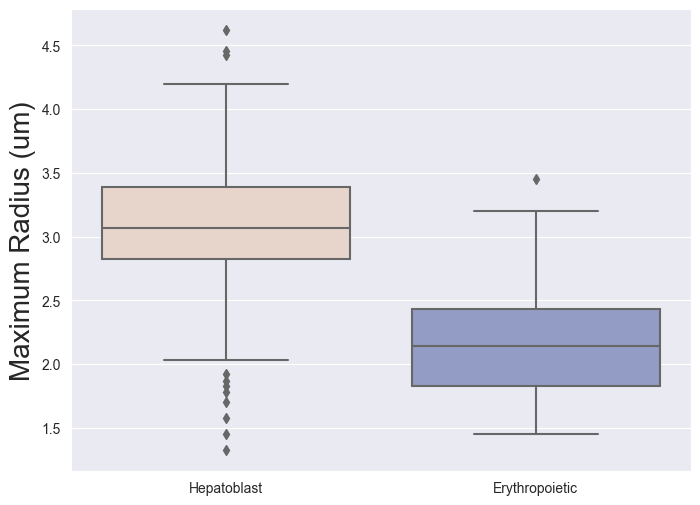

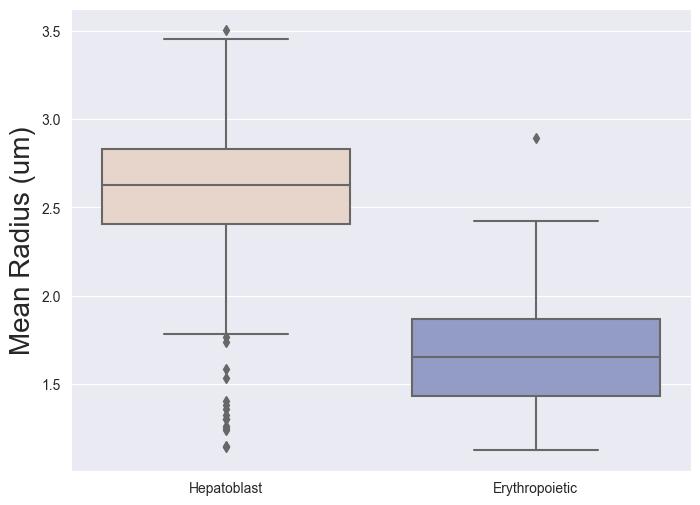

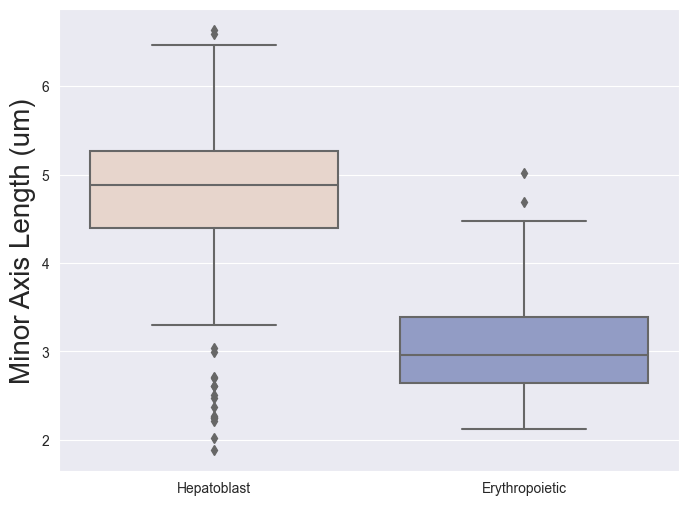

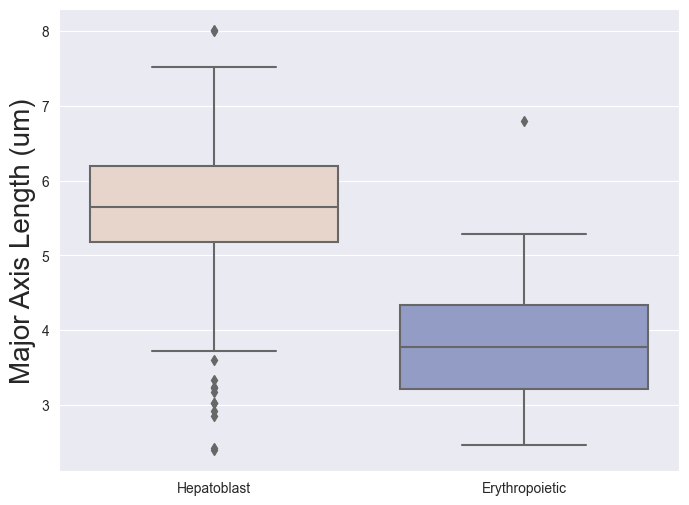

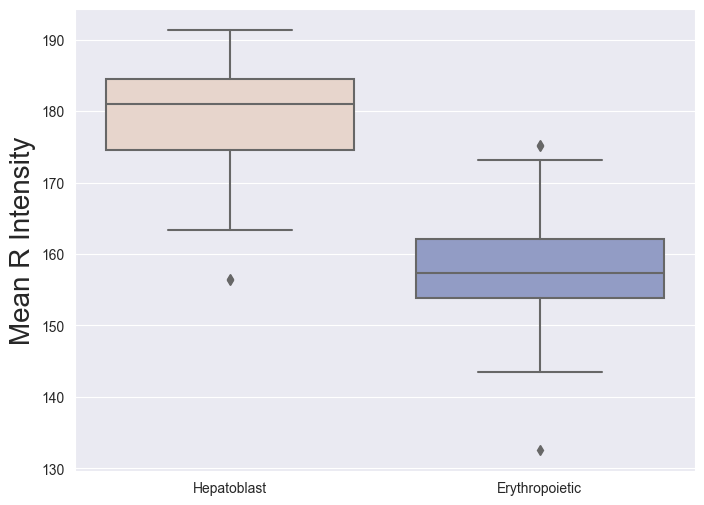

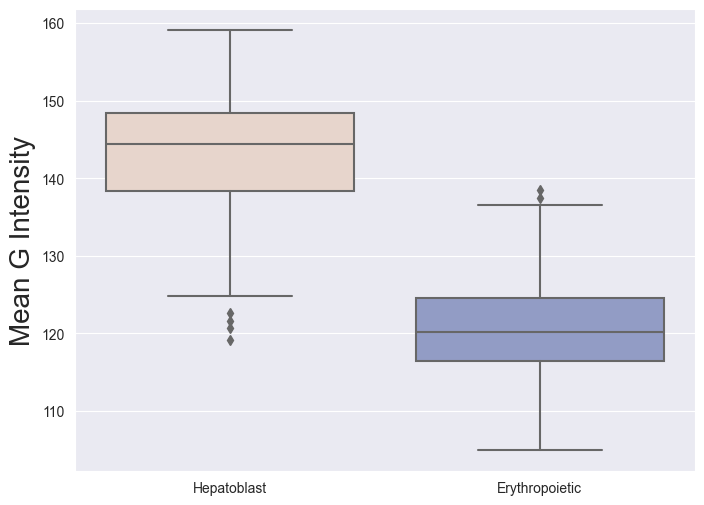

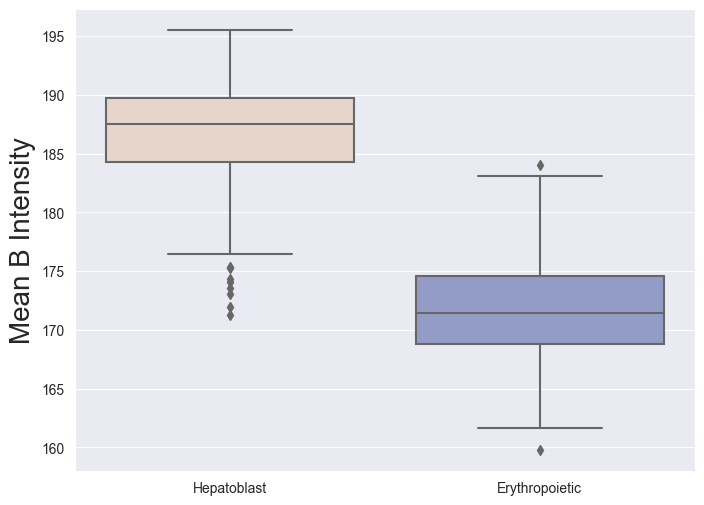

In [62]:
for i in range(len(cols_to_select)):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(x="class", y=f"{cols_to_select[i]}", data=df_combined, palette=cmap)
    ax.set_xticklabels(titles)
    ax.set_xlabel('')
    ax.set_ylabel(f'{good_names[i]}', fontsize=20)
    # plt.savefig(fr'C:\Users\Donald\PycharmProjects\monkey_nuc_segment\Segmentation_Analysis\monkey\stardist_volcell\plots\kidney_nuc_feature_violins\{col}_plot.png', dpi=300)
    # plt.close()  # Close the current figure to free up memory
    plt.show()

In [63]:
from sklearn.decomposition import PCA

In [64]:
norm = df_combined.copy()
norm = norm.iloc[:,2:-3].apply(lambda iterator: ((iterator - iterator.mean())/iterator.std()))
norm.head()

Area  Perimeter  Circularity  Aspect Ratio  compactness  eccentricity  \
0 -0.949672  -0.950876    -0.957791      0.547861     0.876381      0.848672   
1 -0.905575  -1.014714     0.636723     -0.735906    -0.621076     -0.805928   
2  0.976297   1.065974     0.195493      0.788270    -0.232569      1.024456   
3  0.682763   0.711684     0.948689     -0.798662    -0.885006     -0.951531   
4  0.250891   0.329080     0.758422     -0.139353    -0.725066      0.173721   

     extent  form_factor  maximum_radius  mean_radius  median_radius  \
0 -0.163687     0.876380       -0.794670    -0.982918      -1.041274   
1  0.427400    -0.621075       -1.188563    -0.896410      -0.872199   
2  0.487986    -0.232567        1.008726     1.005691       0.937382   
3  0.939763    -0.885005        0.301921     0.787282       0.825546   
4  0.799110    -0.725064        0.310163     0.378993       0.449110   

   minor_axis_length  major_axis_length  orientation_degrees  \
0          -1.032820          -0.884507             1.205024   
1          -0.736968          -1.098833             0.056086   
2           0.660675           1.345181            -0.473856   
3           0.919944           0.526773             0.705987   
4           0.340519           0.361158             1.030045   

   r_mean_intensity  g_mean_intensity  
0         -0.922119         -0.824368  
1         -0.350126         -0.751431  
2          0.711351          0.839515  
3          1.602264          2.096166  
4          1.367437          1.657023

In [65]:
pca2=PCA()
pca2.fit(norm)
pca2.explained_variance_ratio_

array([6.2792248e-01, 1.7344642e-01, 6.3807778e-02, 6.1651509e-02,
       4.5341577e-02, 1.7004894e-02, 5.9412257e-03, 2.5731651e-03,
       1.3067797e-03, 4.1784300e-04, 2.8107813e-04, 1.9958716e-04,
       9.9425721e-05, 5.4475040e-06, 8.4478205e-07, 1.6379064e-14],
      dtype=float32)

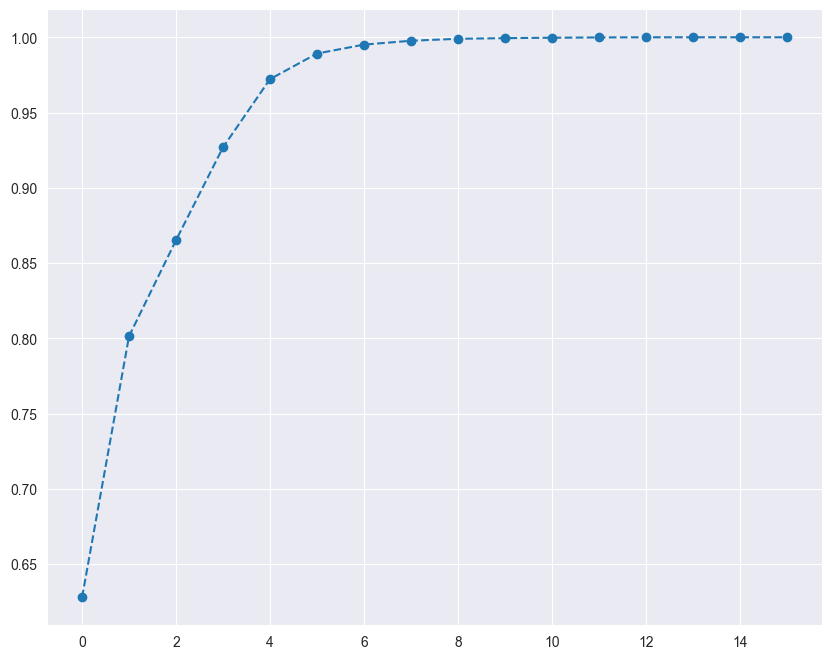

In [66]:
plt.figure(figsize=(10,8))
plt.plot(range(0,len(norm.columns)), pca2.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')

In [67]:
pca = PCA(n_components=2)
pca.fit(norm)
pca.transform(norm)
scores_pca = pca.transform(norm)

In [68]:
color_dict = dict(zip(np.unique(df_combined['class']), cmap))
colors = [color_dict[value] for value in df_combined['class']]

In [69]:
colors

[[0.9215686274509803, 0.8313725490196079, 0.7843137254901961],
 [0.9215686274509803, 0.8313725490196079, 0.7843137254901961],
 [0.9215686274509803, 0.8313725490196079, 0.7843137254901961],
 [0.9215686274509803, 0.8313725490196079, 0.7843137254901961],
 [0.9215686274509803, 0.8313725490196079, 0.7843137254901961],
 [0.9215686274509803, 0.8313725490196079, 0.7843137254901961],
 [0.9215686274509803, 0.8313725490196079, 0.7843137254901961],
 [0.9215686274509803, 0.8313725490196079, 0.7843137254901961],
 [0.9215686274509803, 0.8313725490196079, 0.7843137254901961],
 [0.9215686274509803, 0.8313725490196079, 0.7843137254901961],
 [0.9215686274509803, 0.8313725490196079, 0.7843137254901961],
 [0.9215686274509803, 0.8313725490196079, 0.7843137254901961],
 [0.9215686274509803, 0.8313725490196079, 0.7843137254901961],
 [0.9215686274509803, 0.8313725490196079, 0.7843137254901961],
 [0.9215686274509803, 0.8313725490196079, 0.7843137254901961],
 [0.9215686274509803, 0.8313725490196079, 0.78431372549

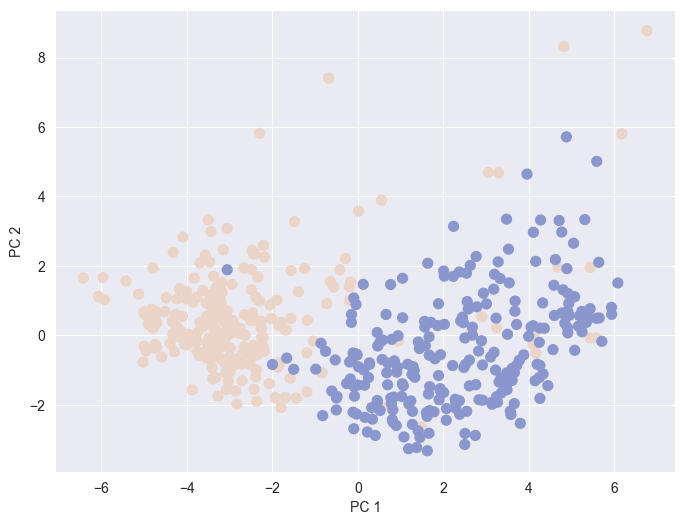

In [72]:
""# Plot the transformed data (principal components)
plt.figure(figsize=(8, 6))
plt.scatter(scores_pca[:, 0], scores_pca[:, 1], color=colors, label='Principal Components', s=50)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
#plt.savefig(fr'C:\Users\Donald\PycharmProjects\monkey_nuc_segment\Segmentation_Analysis\monkey\stardist_volcell\plots\pdfs\pca_plot.png', dpi=300)  # Save the plot as a PDF file
plt.show()